In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dttm
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect = True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [12]:
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [13]:
engine.execute("select * from station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [14]:
pd.DataFrame(session.query(measurement.date).order_by(measurement.date).all()).tail()

,date
19545,2017-08-22
19546,2017-08-23
19547,2017-08-23
19548,2017-08-23
19549,2017-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
datelimit = (dttm.date.today()-dttm.timedelta(365)).isoformat()
session.query(measurement.date).filter(measurement.date>datelimit).all()
# NO DATA EXISTS FOR THE ACTUAL LAST 12 MONTHS



[]

In [16]:
max_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

2016-08-23


Text(0.5, 0, 'measurement date')

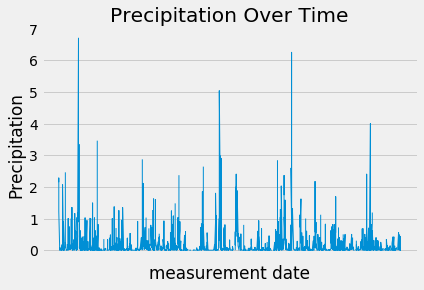

In [39]:
# Calculate the date 1 year ago from the last data point in the database
lastdate = dt.strptime(max_date,'%Y-%m-%d')
datelimit = ((lastdate-dttm.timedelta(365)).isoformat()).split('T')[0]
print(datelimit)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement).filter(measurement.date>datelimit)
dates = []
prec = []
for row in results:
    dates.append(row.date)
    prec.append(row.prcp)
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame({"Date":dates,"Precipitation":prec})
prec_df.set_index('Date')
# Sort the dataframe by date
prec_df = prec_df.sort_values("Date")
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prec_df["Date"], prec_df["Precipitation"],linewidth = 1)
plt.xticks([])
plt.title('Precipitation Over Time')
plt.ylabel('Precipitation')
plt.xlabel('measurement date')

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(station.name).count()

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rank = session.query(measurement.station,func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
station_rank

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_station = station_rank[0][0]
temperature_aggregates = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == max_station).group_by(measurement.station).all()
temperature_aggregates

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'measurement date')

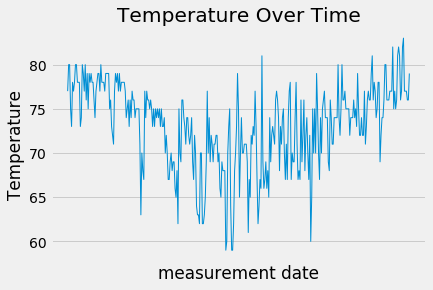

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_station_temp = session.query(measurement.date,measurement.tobs).filter(measurement.date>datelimit).filter(measurement.station == max_station).all()
tobs_df = pd.DataFrame(max_station_temp)  
tobs_df.head()

plt.plot(tobs_df["date"], tobs_df["tobs"], linewidth = 1)
plt.xticks([])
plt.title('Temperature Over Time')
plt.ylabel('Temperature')
plt.xlabel('measurement date')

## Bonus Challenge Assignment

### Bonus - Temperature Analysis I

In [23]:
measurement_df = pd.read_csv("./Resources/hawaii_measurements.csv")
months = []
for row in measurement_df.iterrows():
    months.append(dt.strptime(row[1]["date"],'%Y-%m-%d').month)

measurement_df['month'] = months

In [50]:
june_df = measurement_df.loc[measurement_df['month']==6]
december_df = measurement_df.loc[measurement_df['month']==12]

june_agg = june_df.groupby('station')
december_agg = december_df.groupby('station')

june = june_agg.mean()[['tobs']].sort_values("station")
december = december_agg.mean()[['tobs']].sort_values("station")

from scipy.stats import ttest_rel
t = ttest_rel(june['tobs'], december['tobs'])

print(f'The p value of this query is {t[1]}, which is below a prescribed alpha of 0.05.')

The p value of this query is 0.00011759380231523222, which is below a prescribed alpha of 0.05.


The results of this t-test indicate a statistically significant difference between average temperatures in June and December at each station. For this test, I've chosen to do a paired t-test to compare the average temperatures at each respective station in the two compared months. This ensures the variation due to location was accounted for in the comparison.